# MVTecAD Hazelnut の SimpleCNN による結果

## Preset

In [1]:
# default packages
import logging
import os
import pathlib
import typing as t

In [2]:
# third party packages
import IPython
import matplotlib.pyplot as plt
import torch
import torch.cuda as tc
import torch.nn as nn
import torch.utils.data as td
import torchvision.transforms as tv_transforms

In [3]:
# my packages
import src.data.dataset_torch as ds
import src.data.directories as directories
import src.data.mvtecad as mvtecad
import src.data.mvtecad_torch as mvtecad_torch
import src.models.cnn_ae as cnn_ae

In [4]:
IPython.get_ipython().run_line_magic("load_ext", "autoreload")
IPython.get_ipython().run_line_magic("autoreload", "2")

In [5]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
def cd_project_root_() -> None:
    """ルートディレクトリをプロジェクトルートに移動."""
    current = pathlib.Path().resolve()
    if current.stem == "notebooks":
        os.chdir(current.parent)

    current = pathlib.Path().resolve()
    logger.info(f"current path: {current}")


cd_project_root_()

INFO:__main__:current path: /home/disii/src/github.com/iimuz/til/machine_learning/torch_anomaly_detection


In [7]:
USE_GPU = tc.is_available()

## Dataset

In [9]:
def create_dataset_() -> td.DataLoader:
    batch_size = 8
    num_workers = 4
    transforms = tv_transforms.Compose(
        [
            tv_transforms.Resize((64, 64)),
            tv_transforms.ToTensor(),
        ]
    )

    kind = mvtecad.Kind.HAZELNUT
    dataset = mvtecad_torch.DatasetAE(kind, transforms, mode=ds.Mode.TRAIN)
    dataloader = td.DataLoader(
        dataset,
        batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader


DATALOADER = create_dataset_()

## Network

In [10]:
def create_network_() -> nn.Module:
    network = cnn_ae.SimpleCBR(in_channels=3, out_channels=3)
    network.load_state_dict(
        torch.load(
            directories.get_processed().joinpath(
                "simple_cbr_mvtecad_hazelnut", "epoch=1"
            )
        )
    )
    if USE_GPU:
        network = network.cuda()
    network.eval()

    return network


NETWORK = create_network_()

## Test

In [11]:
def show_images(batch: torch.Tensor, decode: torch.Tensor) -> None:
    batch_cpu = batch.detach().cpu().numpy().transpose(0, 2, 3, 1)
    decode_cpu = decode.detach().cpu().numpy().transpose(0, 2, 3, 1)

    rows, cols = 2, batch_cpu.shape[0]
    figsize = (4 * cols, 4 * rows)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for idx in range(cols):
        ax = axes[0, idx]
        ax.imshow(batch_cpu[idx])

        ax = axes[1, idx]
        ax.imshow(decode_cpu[idx])

    plt.show()
    fig.clf()
    plt.close()

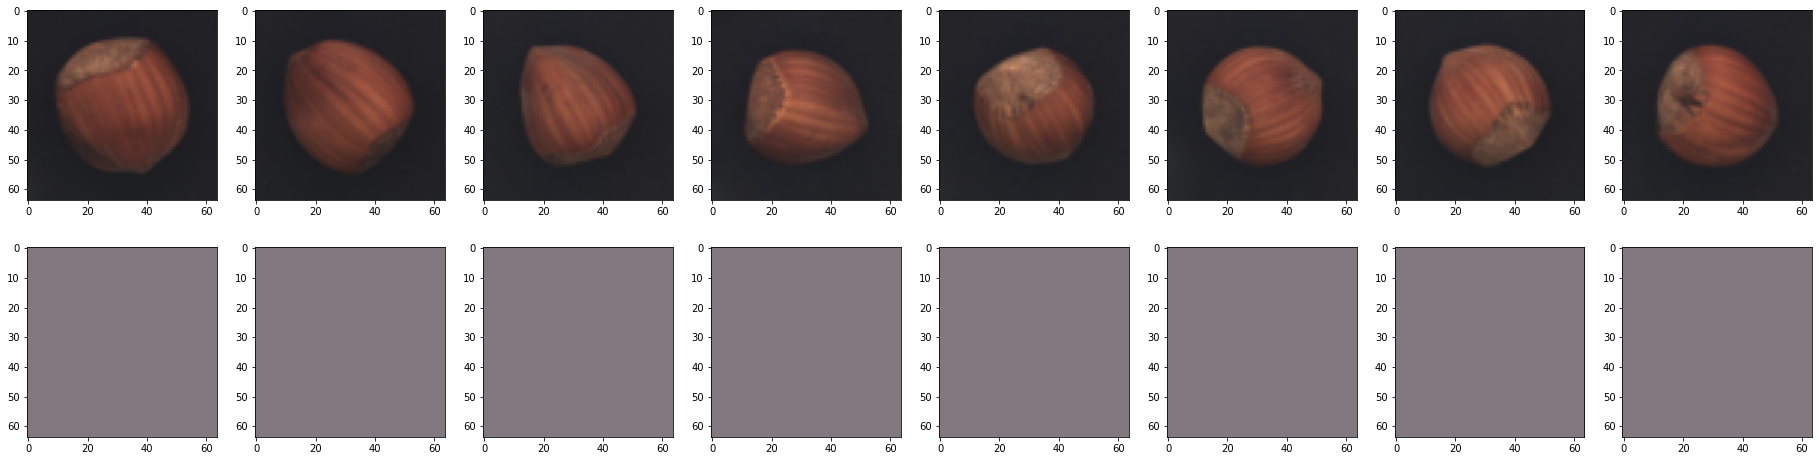

In [13]:
def test_() -> None:
    with torch.no_grad():
        for batch in DATALOADER:
            if USE_GPU:
                batch = batch.cuda()

            output = NETWORK(batch)
            show_images(batch, output)
            break


test_()